# Waveome and Breastmilk data   
In this tutorial we are going to use waveome on the HIV-AIDS data which were studied by Wang (2013) and it is the bivariate responses of HIV-1 RNA (count/ml) in seminal and blood of patients in HIV-RNA AIDS studies from Seattle, Swiss and UNCCH cohorts. The data were collected out of N=149 subjects divided into two groups of patients who were receiving a therapy (14=106 patients) and those with no therapy or unknown therapy method (43 patients). The covariate are scaled time, baseline age, baseline CD4 and two factors consists of group and cohort.  MtLMM with DEC correlation structure achieved lower AIC compare to other types of correlation and also compare to simple LMM with normal distribution. But, here we are going to confirm the results of Wang (2013) by waveome.

## Setup

In [1]:
from waveome.model_search import GPSearch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

2024-04-15 18:09:36.769225: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Here we are going to read the biomarkers and the covariates. The data has not been seperated into data and metadata.

In [4]:
dfHIVRNA = pd.read_csv("/Users/alireza/Desktop/Research/Waveome Codes/Projects/HIVRNA1492.txt",delimiter='\t', header=0, dtype='float')

# new_column_names = dfHIVRNA.iloc[0]
# dfHIVRNA.columns = new_column_names

# dfHIVRNA = dfHIVRNA.drop([0,1])
# dfHIVRNA.reset_index(drop=True, inplace=True)
dfHIVRNA['index'] = dfHIVRNA['Subject'].astype(int)

dfHIVRNA['time'] = dfHIVRNA['week'].astype(int)
# type(dfHIVRNA)
# # dfinfantMetadata = pd.read_csv("/Users/alireza/Desktop/Research/Waveome Codes/Projects/infant_metadata.csv",header=None)
# # dfinfantMetadata = pd.read_csv("/Users/rahlab/Desktop/AliReza/waveome/infant_metadata.csv",header=None)

print(dfHIVRNA.head(10))

   Subject   age  week  cd4.base    cd4  trt      SPRNA  LSPRNA     BPRNA  \
0      1.0  37.0   0.0      60.0   60.0  0.0    15849.0    4.20  165959.0   
1      1.0  37.0  14.0      60.0   60.0  1.0      400.0    2.60     200.0   
2      2.0  40.0   0.0     340.0  340.0  0.0  3981072.0    6.60  102329.0   
3      2.0  40.0  12.0     340.0  250.0  1.0   660693.0    5.82   10965.0   
4      2.0  40.0  26.0     340.0  400.0  1.0  3467369.0    6.54   10471.0   
5      3.0  60.0   0.0     110.0  110.0  0.0   204174.0    5.31  158489.0   
6      3.0  60.0   9.0     110.0  150.0  1.0     1000.0    3.00     676.0   
7      3.0  60.0  26.0     110.0   70.0  1.0     1000.0    3.00    1000.0   
8      4.0  33.0   0.0     230.0  230.0  0.0  3981072.0    6.60   87096.0   
9      4.0  33.0  12.0     230.0  360.0  1.0  4466836.0    6.65   26915.0   

   LBPRNA  area1  area2  index  time  
0    5.22    1.0    0.0      1     0  
1    2.30    1.0    0.0      1    14  
2    5.01    1.0    0.0      2     

Remember that we alignined the 'time' by 'week of visist' of the subject. 

We need to map the categorical data into numeric to use in waveoem. This is in case that you want to use them as dummy variables. However, we are going to use them directly as categorical variables with multiple values rather than binary. 

In [5]:
for column_name in dfHIVRNA.columns:
    column_type = dfHIVRNA[column_name].dtype
    print(f"Column '{column_name}' is {column_type}")

Column 'Subject' is float64
Column 'age' is float64
Column 'week' is float64
Column 'cd4.base' is float64
Column 'cd4' is float64
Column 'trt' is float64
Column 'SPRNA' is float64
Column 'LSPRNA' is float64
Column 'BPRNA' is float64
Column 'LBPRNA' is float64
Column 'area1' is float64
Column 'area2' is float64
Column 'index' is int64
Column 'time' is int64


Now we are going to plot the variables and more interestingly the response variables against the time. Please consider in mind here that 'time' in this project is the week of visist. 

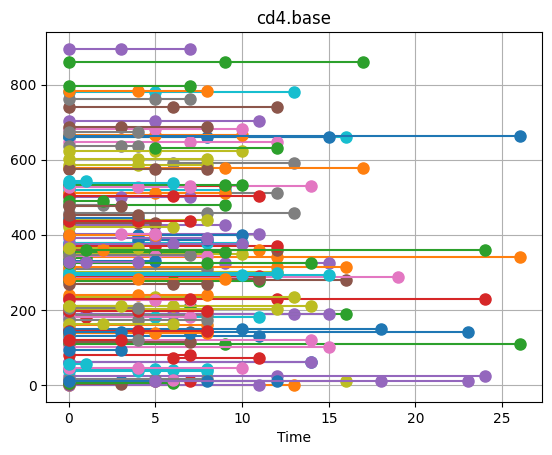

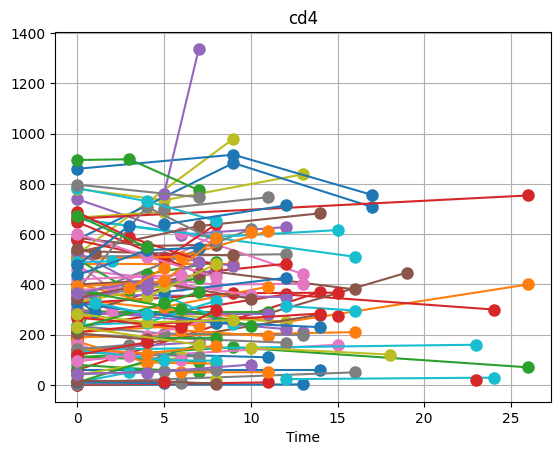

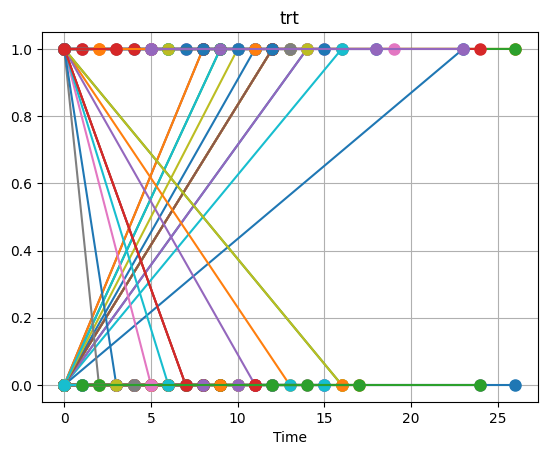

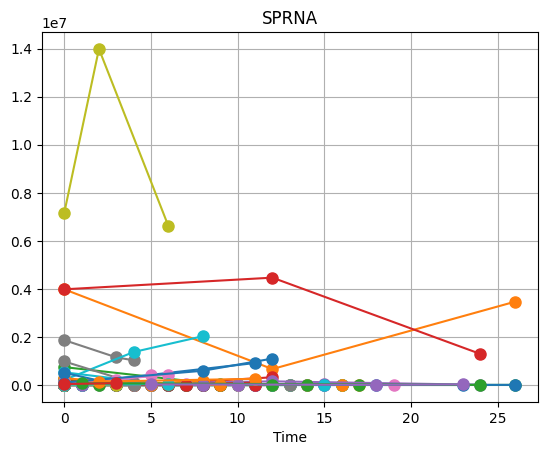

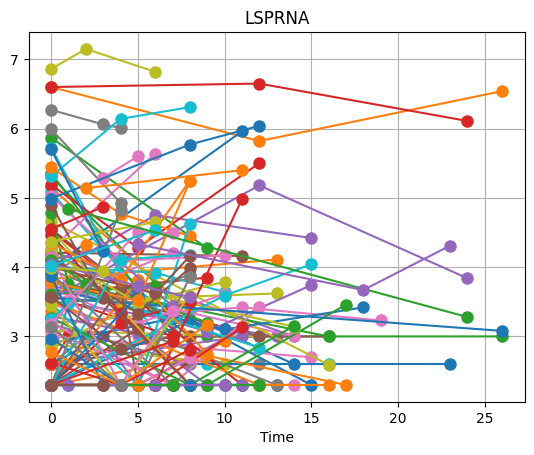

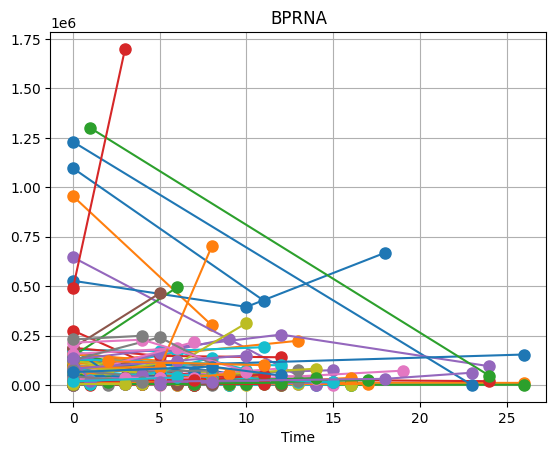

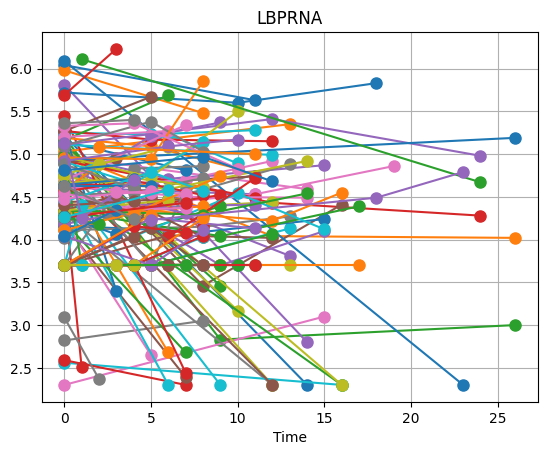

In [14]:
# Get the unique index values
unique_indexes = dfHIVRNA['index'].unique()


# Column names excluding non microbiome columns
column_names = dfHIVRNA.columns[3:10]
# Iterate over the columns
for out in column_names:
    # Initialize a list to store the indexes with at least two measurements
    valid_indexes = []
    # Check for each index if it has at least two measurements
    for i in unique_indexes:
        if dfHIVRNA.loc[dfHIVRNA['index'] == i, out].count() >= 2:
            valid_indexes.append(i)
        # Plot data for valid indexes
    for i in valid_indexes:
        plt.plot(dfHIVRNA.loc[dfHIVRNA['index'] == i, 'time'], dfHIVRNA.loc[dfHIVRNA['index'] == i, out], marker='o', markersize=8, linestyle='-')
    plt.title(out)
    plt.xlabel('Time')
    plt.grid(True)
    plt.show()

We use waveome on the variables simultanuously. But keep in mind that waveome will use univariate model for each response. 
"It should be emphasized that the availability of multivariate longitudinal data does not
necessarily require the construction of a joint model for all outcomes simultaneously. In
some cases, univariate longitudinal models for each outcome separately may answer all
research questions." Verbeke et al (2014)

In [6]:
# dfHIVRNA = dfHIVRNA.dropna
gps = GPSearch(
       X=dfHIVRNA[['index','time','trt']].astype(float),
       Y=dfHIVRNA[['SPRNA', 'BPRNA']].astype(float),
       unit_col='index',
       categorical_vars=['trt'],
       outcome_likelihood= 'gaussian'
)#'gaussian')

In [7]:
gps.run_search(
    random_seed=9102
)

Kernel search: 100%|██████████████████████████████| 2/2 [01:21<00:00, 40.56s/it]


Check for both the outputs model fitting features seperately on each response variable:

In [17]:
gps.models["SPRNA"]

{'models': {'categorical[0]': {'kernel': <waveome.kernels.Categorical object at 0x7fe2a4ea34f0>
╒══════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                 │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞══════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Categorical.variance │ Parameter │ Softplus    │ Uniform │ True        │ ()      │ float64 │ 0.67957 │
╘══════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛,
   'model': <gpflow.models.gpr.GPR object at 0x7fe2a4ea3ca0>
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════

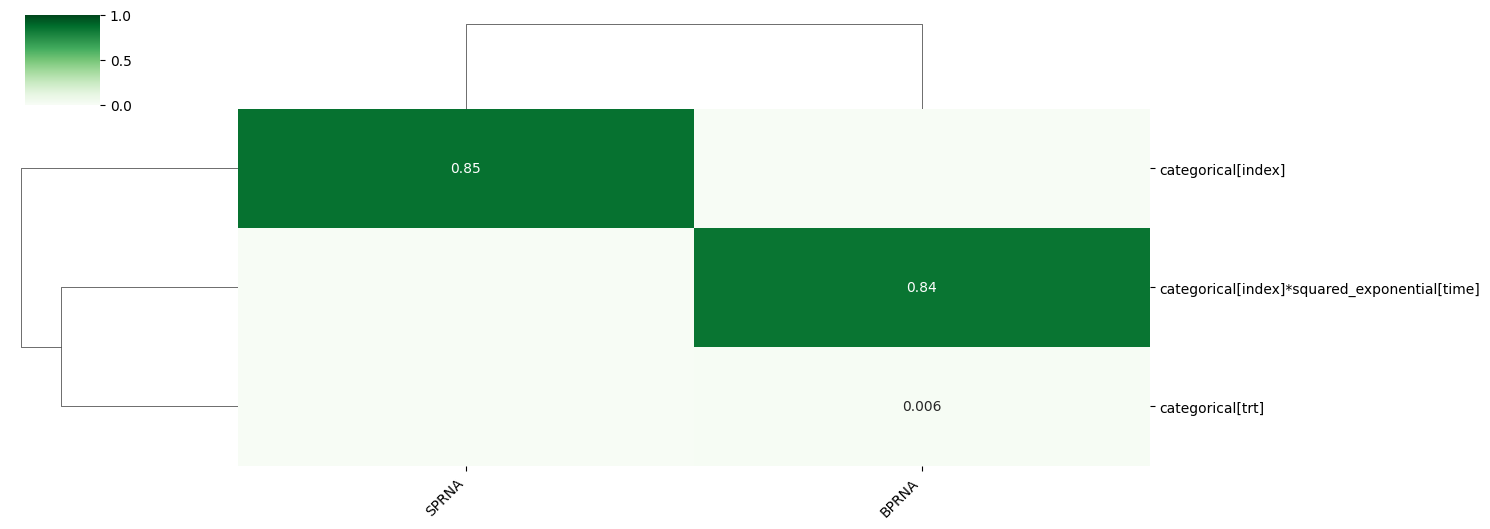

In [8]:
gps.plot_heatmap(var_cutoff=0.1);

(<Figure size 2000x500 with 2 Axes>,
 array([[<Axes: title={'center': 'categorical[index](85.2%)'}, xlabel='time'>,
         <Axes: title={'center': 'residuals (14.8%)'}, xlabel='time'>,
         <Axes: >, <Axes: >]], dtype=object))

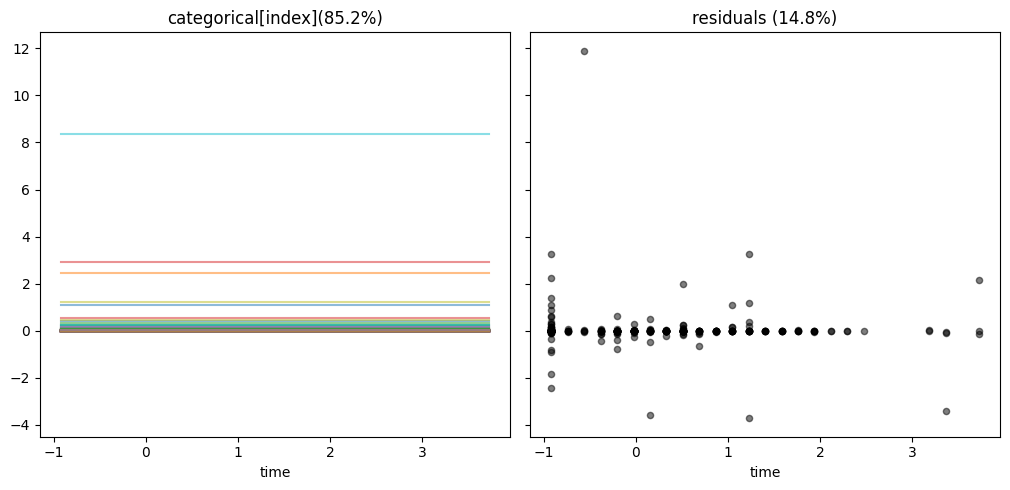

In [9]:
gps.plot_parts(
    out_label='SPRNA', 
    x_axis_label='time',
    unit_label=0
)

(<Figure size 2000x500 with 3 Axes>,
 array([[<Axes: title={'center': 'categorical[index]*\nsquared_exponential[time](84.1%)'}, xlabel='time'>,
         <Axes: title={'center': 'categorical[trt](0.6%)'}, xlabel='time'>,
         <Axes: title={'center': 'residuals (15.3%)'}, xlabel='time'>,
         <Axes: >]], dtype=object))

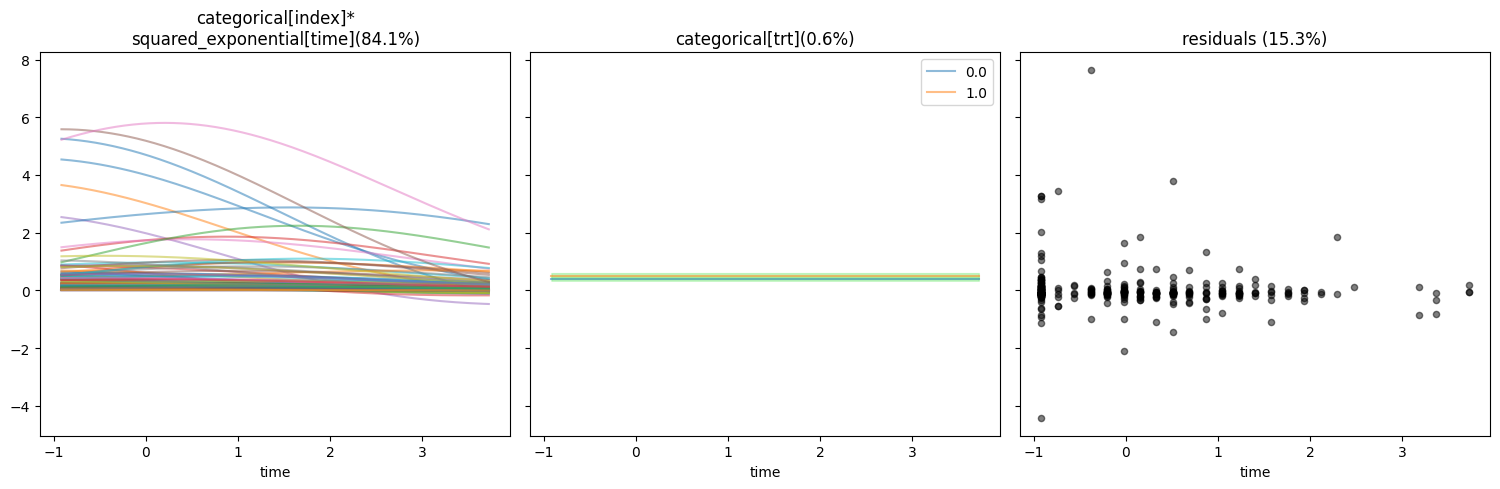

In [10]:
gps.plot_parts(
    out_label='BPRNA', 
    x_axis_label='time',
    unit_label=0
)

From this quick tutorial we have seen how to use waveome to model longitudinal data.